In [356]:
import pandas, requests, datetime, shapely, json, pickle, re
from pymongo import MongoClient
from collections import defaultdict

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
routes_ = pandas.read_csv('raw_data/routes.csv')

In [265]:
reservations_ = pandas.read_csv('raw_data/reservations.csv')

In [4]:
routes_['created_at'] = routes_.created_at.apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S.%f'))
routes_['start_time'] = routes_.start_time.apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))

In [ ]:
routes_ = routes_[routes_.created_at > datetime.date(2015, 5, 23)]

In [203]:
all_legs_with_routes = pandas.read_excel('processed_data/all_legs_with_routes.xlsx')

In [40]:
len(all_legs_with_routes)

1512

In [41]:
len(all_legs_with_routes.event_id.unique())

871

In [307]:
all_legs_with_routes.head()

event_id  leg_id state_origin state_dest is_public  bus_size  go_live  \
0      1317    2512           NY         NY     False        12        1   
1      1323    2519           ME         ME     False        12        0   
2      1323    2520           ME         ME     False        12        0   
3      1324    2521           MN         WI      True        55       15   
4      1325    2522           WI         MN      True        55       15   

               created_at  live_ratio          start_time  \
0 2015-06-24 19:40:38.237        0.08 2015-06-26 13:00:00   
1 2015-06-25 14:12:20.580        0.00 2015-07-11 23:30:00   
2 2015-06-25 14:12:20.580        0.00 2015-06-28 06:00:00   
3 2015-06-25 15:28:15.616        0.27 2015-08-14 18:00:00   
4 2015-06-25 15:30:22.213        0.27 2015-08-15 06:00:00   

                         ...                         dist_meters  \
0                        ...                                1097   
1                        ...                               29108   
2                        ...                               30117   
3                        ...                               59607   
4                        ...                               58362   

   duration_text duration_sec  \
0         5 mins          296   
1        24 mins         1456   
2        26 mins         1573   
3        52 mins         3131   
4        51 mins         3036   

                                       geometry_line  \
0  {"type": "LineString", "coordinates": [[-73.97...   
1  {"type": "LineString", "coordinates": [[-70.45...   
2  {"type": "LineString", "coordinates": [[-70.25...   
3  {"type": "LineString", "coordinates": [[-93.27...   
4  {"type": "LineString", "coordinates": [[-92.68...   

                                start_address_f  \
0           767 5th Avenue, New York, NY, 10153   
1                          Biddeford, ME, 04005   
2                                  Portland, ME   
3  701 North 1st Avenue, Minneapolis, MN, 55403   
4        715 Spring Street, Somerset, WI, 54025   

                                  end_address_f riders_final  went_live  \
0     569 Lexington Avenue, New York, NY, 10022            0      False   
1                                  Portland, ME           12       True   
2                          Biddeford, ME, 04005           12       True   
3        715 Spring Street, Somerset, WI, 54025           19       True   
4  701 North 1st Avenue, Minneapolis, MN, 55403           18       True   

                                   geometry_marker_e  \
0  {"coordinates": [-73.97207, 40.75692], "type":...   
1  {"coordinates": [-70.25545, 43.66142], "type":...   
2  {"coordinates": [-70.45339, 43.49257], "type":...   
3  {"coordinates": [-92.68489, 45.13066], "type":...   
4  {"coordinates": [-93.27639, 44.97849], "type":...   

                                   geometry_marker_s  
0  {"coordinates": [-73.97327, 40.76393], "type":...  
1  {"coordinates": [-70.45339, 43.49257], "type":...  
2  {"coordinates": [-70.25545, 43.66142], "type":...  
3  {"coordinates": [-93.27639, 44.97849], "type":...  
4  {"coordinates": [-92.68489, 45.13066], "type":...  

[5 rows x 21 columns]

In [102]:
#all_legs_with_routes.drop(['riders_final_x', 'riders_final_y', 'went_live_x', 'went_live_y'], axis=1, inplace=True)

In [267]:
len(reservations_)

6336

In [268]:
reservations_ = reservations_[reservations_.event_id.isin(all_legs_with_routes.event_id.unique().tolist())]
len(reservations_)

4660

In [269]:
reservations_.tail()

created_at  event_id  res_id
6307  2016-02-23 01:30:52.052309      3652    8997
6308  2016-02-23 21:44:35.495079      3672    9009
6309   2016-02-24 02:28:47.67455      3690    9012
6310  2016-02-24 08:44:03.751892      3698    9015
6311  2016-02-24 23:32:21.964965      3711    9032

In [270]:
reservations_['created_at'] = reservations_.created_at.apply(lambda dt: datetime.datetime.strptime(str(dt), '%Y-%m-%d %H:%M:%S.%f'))

In [271]:
reservations_.head(10)

created_at  event_id  res_id
1639 2015-08-14 04:59:08.266282      1324    3983
1640 2015-08-10 20:00:05.447071      1324    3651
1641 2015-08-11 16:45:30.026808      1324    3675
1642 2015-08-11 16:45:30.871630      1324    3679
1643 2015-08-10 17:32:34.619424      1324    3644
1644 2015-08-10 17:32:34.423316      1324    3643
1645 2015-08-14 02:29:14.343259      1324    3978
1646 2015-07-06 21:24:57.413689      1324    2595
1647 2015-08-11 13:05:51.347258      1324    3668
1648 2015-08-10 16:59:55.679642      1324    3641

In [12]:
riders_final = reservations_.groupby('event_id')['res_id'].count().reset_index()
riders_final.columns = ['event_id', 'riders_final']
riders_final.head()

event_id  riders_final
0      1324            19
1      1325            18
2      1326            22
3      1327            21
4      1328            33

In [14]:
a=len(riders_final)
b=len(all_legs_with_routes.event_id.unique())
a, b, a/b

(240, 871, 0.2755453501722158)

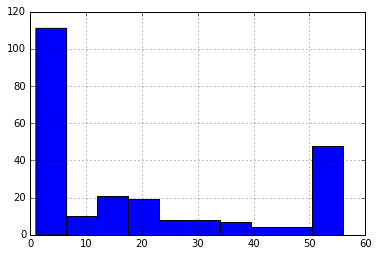

In [15]:
riders_final.riders_final.hist()

In [16]:
all_rides_final = riders_final.merge(all_legs_with_routes[['event_id', 'bus_size', 'go_live']].drop_duplicates(), on='event_id', how='right')

In [241]:
all_rides_final['went_live'] = all_rides_final.riders_final >= all_rides_final.go_live
all_rides_final.riders_final.fillna(0, inplace=True)

In [236]:
all_rides_final = all_rides_final.apply(substitute_rider_counts, axis=1)

In [237]:
len(all_rides_final)

871

In [296]:
all_rides_final.tail()

event_id  riders_final  bus_size  go_live went_live
866      3704             0        55       10     False
867      3706            23        23        0      True
868      3707             0        55       10     False
869      3708            54        54        0      True
870      3712             0        55       10     False

In [242]:
all_rides_final.went_live.value_counts()

False    589
True     282
Name: went_live, dtype: int64

In [103]:
all_legs_with_routes = all_legs_with_routes.merge(all_rides_final[['event_id', 'riders_final', 'went_live']], on='event_id', how='left')

In [ ]:
def reorder_latlon_to_lonlat(geometry_):
    x=json.loads(geometry_.replace('\'', '"'))
    try: 
        x['coordinates'] = [[a[1], a[0]] for a in x['coordinates']]
    except:
        x['coordinates'] = x['coordinates'][::-1]
    return json.dumps(x)

In [117]:
all_legs_with_routes['geometry_marker'] = all_legs_with_routes.geometry_marker.apply(reorder_latlon_to_lonlat)
all_legs_with_routes['geometry_line'] = all_legs_with_routes.geometry_line.apply(reorder_latlon_to_lonlat)

In [ ]:
all_legs_HQ_polylines = pandas.read_excel('processed_data/all_legs_with_routes_hq_polylines.xlsx')
all_legs_with_routes = pandas.read_excel('processed_data/all_legs_with_routes.xlsx')

In [228]:
#go_live of 0 means bus is paid for, so I can substitute riders_final to be full
def substitute_rider_counts(row):
    if row.go_live == 0:
        row.riders_final = row.bus_size
    return row

In [234]:
all_legs_with_routes = all_legs_with_routes.apply(substitute_rider_counts, axis=1)
all_legs_HQ_polylines = all_legs_HQ_polylines.apply(substitute_rider_counts, axis=1)

In [243]:
all_legs_with_routes.went_live = all_legs_with_routes.riders_final >= all_legs_with_routes.go_live
all_legs_HQ_polylines.went_live = all_legs_HQ_polylines.riders_final >= all_legs_HQ_polylines.go_live

In [244]:
all_legs_with_routes.to_excel('processed_data/all_legs_with_routes.xlsx')
all_legs_HQ_polylines.to_excel('processed_data/all_legs_with_routes_hq_polylines.xlsx')

In [318]:
all_rides_legs_final = all_legs_with_routes[['event_id', 'leg_id', 'is_public']].merge(all_rides_final, on='event_id', how='left')
all_rides_legs_final.head()

event_id  leg_id is_public  riders_final  bus_size  go_live went_live
0      1317    2512     False             0        12        1     False
1      1323    2519     False            12        12        0      True
2      1323    2520     False            12        12        0      True
3      1324    2521      True            19        55       15      True
4      1325    2522      True            18        55       15      True

In [272]:
reservations_ = reservations_.merge(all_legs_with_routes[['event_id', 'leg_id']], on='event_id', how='right')
len(reservations_)

8744

In [273]:
len(all_rides_legs_final[all_rides_legs_final.go_live == 0])

290

### Data with granularity to the hour
Scroll down for granularity to the day 

In [50]:
onehour = datetime.timedelta(hours=1)

beginning = datetime.datetime(2015, 5, 23)

datetime.date(2016,2,24) - datetime.date(2015,5,23)

datetime.timedelta(277)

In [59]:
all_routes = all_legs_with_routes[['leg_id', 'created_at','start_time']].drop_duplicates(subset='leg_id')
all_routes.head()

leg_id              created_at          start_time
0    2512 2015-06-24 19:40:38.237 2015-06-26 13:00:00
1    2519 2015-06-25 14:12:20.580 2015-07-11 23:30:00
2    2520 2015-06-25 14:12:20.580 2015-06-28 06:00:00
3    2521 2015-06-25 15:28:15.616 2015-08-14 18:00:00
4    2522 2015-06-25 15:30:22.213 2015-08-15 06:00:00

In [60]:
hour_frames_dict = dict()
for hour_frame in range(277*24):
    hf_datetime = beginning + hour_frame * onehour
    hf_dict = dict()
    for route_leg_id in all_routes[(all_routes.created_at < hf_datetime) & (all_routes.start_time + 12*onehour > hf_datetime)]['leg_id']:
        #check if it's a fully paid route
        dta = all_rides_legs_final[all_rides_legs_final.leg_id == route_leg_id]
        if dta.go_live.tolist()[0] == 0:
            hf_dict[route_leg_id] = dta.bus_size.tolist()[0]
        else:
            hf_dict[route_leg_id] = len(reservations_[(reservations_.leg_id == route_leg_id) & (reservations_.created_at < hf_datetime + onehour)])
    hour_frames_dict[hour_frame] = hf_dict.copy()

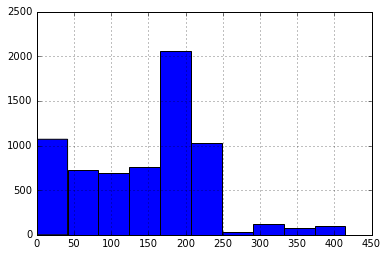

In [75]:
pandas.Series([len(x) for x in hour_frames_dict.values()]).hist()

In [89]:
full_hour_frames_dict = dict()

for hour_frame in range(277*24):
    hf_list = list()
    for route_leg_id in hour_frames_dict[hour_frame].keys():
        r_n = hour_frames_dict[hour_frame][route_leg_id]
        try:
            full_cap, live_thr, publ = [int(x) for x in all_rides_legs_final[all_rides_legs_final.leg_id == route_leg_id][['bus_size', 'go_live', 'is_public']].as_matrix()[0]]
            r_n / full_cap
        except:
            print('skipping', hour_frame, ':', route_leg_id)
            continue
        
        try:
            p_t_l = min(r_n / live_thr, 1)
        except:
            p_t_l = 1
            
        if p_t_l < 0.6:
            color = 'red'
        elif p_t_l < 1:
            color = 'yellow'
        else:
            color = 'green'
            
        newroute = { 'leg_id' : route_leg_id, 'reservations_now' : r_n,
                     'progress_to_live' : np.round(p_t_l, 2),
                     'percent_of_full' : np.round(r_n / full_cap, 2),
                     'live_color' : color, 
                    }
        hf_list.append(newroute)
    full_hour_frames_dict[hour_frame] = hf_list[:]

skipping 3186 : 3097


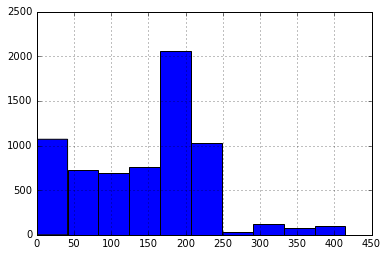

In [95]:
pandas.Series([len(x) for x in full_hour_frames_dict.values()]).hist()

## Data with granularity to the day

In [253]:
oneday = datetime.timedelta(days=1)

beginning = datetime.datetime(2015, 5, 24)

datetime.date(2016,2,24) - datetime.date(2015,5,23)

datetime.timedelta(277)

In [274]:
day_frames_dict = dict()
for day_frame in range(277):
    df_datetime = beginning + day_frame * oneday
    df_dict = dict()
    for route_leg_id in all_routes[(all_routes.created_at <= df_datetime) & (all_routes.start_time + oneday >= df_datetime)]['leg_id']:
        #check if it's a fully paid route
        dta = all_rides_legs_final[all_rides_legs_final.leg_id == route_leg_id]
        if dta.go_live.tolist()[0] == 0:
            df_dict[route_leg_id] = dta.bus_size.tolist()[0]
        else:
            df_dict[route_leg_id] = len(reservations_[(reservations_.leg_id == route_leg_id) & (reservations_.created_at <= df_datetime + oneday)])
    day_frames_dict[day_frame] = df_dict.copy()

In [298]:
def is_starting_today(frame, leg_id):
    frame_date = beginning + oneday*frame
    start_d = all_routes[all_routes.leg_id == leg_id].start_time.tolist()[0]
    if abs(frame_date - start_d) < oneday:
        if all_rides_legs_final[all_rides_legs_final.leg_id == leg_id].went_live.tolist()[0] == True:
            return 'success'
        else:
            return 'disappear'
    else: 
        return False

def is_going_live(frame, leg_id):
    #did I go live at all?
    leg_info = all_rides_legs_final[all_rides_legs_final.leg_id == leg_id]
    if leg_info.went_live.tolist()[0] == True:
        #did it happen today?
        golive = leg_info.go_live.tolist()[0]
        res_today = day_frames_dict[frame][leg_id]
        res_yesterday = day_frames_dict[frame-1][leg_id]
        try:
            if res_today / float(go_live) >= 1:
                if res_yesterday / float(go_live) < 1:
                    return 'golive'
        except:
            return False
    return False

def is_going_red_to_yellow(frame, leg_id):
    #did I go live at all?
    leg_info = all_rides_legs_final[all_rides_legs_final.leg_id == leg_id]
    if leg_info.went_live.tolist()[0] == True:
        #did it happen today?
        golive = leg_info.go_live.tolist()[0]
        res_today = day_frames_dict[frame][leg_id]
        res_yesterday = day_frames_dict[frame-1][leg_id]
        try:
            if res_today / float(go_live) >= 0.5:
                if res_yesterday / float(go_live) < 0.5:
                    return 'goyellow'
        except:
            return False
    return False

In [439]:
day_frames_animations = dict()
day_frames_animations[0] = defaultdict(int)
for frame_no in range(1, len(day_frames_dict)): # don't bother with the first day
    day_frame = day_frames_dict[frame_no]
    dfa_dict = defaultdict(int)
    for route_leg_id in day_frame:
        #am I happening today?
        ist = is_starting_today(frame_no, route_leg_id)
        if ist != False:
            dfa_dict[route_leg_id] = ist
            continue
        #did I just appear?
        try:
            #was I there the previous day?
            res_yesterday = day_frames_dict[frame_no-1][route_leg_id]
        except:
            #keyError: Not? Means I appeared
            dfa_dict[route_leg_id] = 'appear'
            continue
        #am I going live?
        igl = is_going_live(frame_no, route_leg_id)
        if igl != False:
            dfa_dict[route_leg_id] = igl
            continue
        # red to yellow? not doing that
#         igrty = is_going_red_to_yellow(frame_no, route_leg_id)
#         if igrty != False:
#             dfa_dict[route_leg_id] = igrty
#             continue
        # no animation
        dfa_dict[route_leg_id] = 0
    day_frames_animations[frame_no] = dfa_dict.copy()

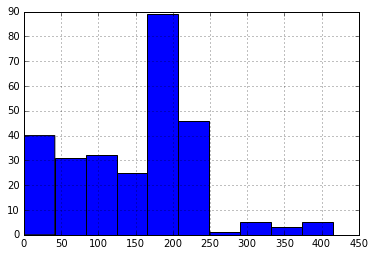

In [275]:
pandas.Series([len(x) for x in day_frames_dict.values()]).hist()

In [440]:
full_day_frames_dict = dict()

for day_frame in range(277):
    df_list = list()
    for route_leg_id in day_frames_dict[day_frame].keys():
        r_n = day_frames_dict[day_frame][route_leg_id]
        try:
            full_cap, live_thr, publ = [int(x) for x in \
                all_rides_legs_final[all_rides_legs_final.leg_id == route_leg_id]
                                        [['bus_size', 'go_live', 'is_public']].as_matrix()[0]]
            r_n / full_cap
        except:
            continue
        
        try:
            p_t_l = min(r_n / live_thr, 1)
        except:
            p_t_l = 1
            
        if p_t_l < 0.5:
            color = 'red'
        elif p_t_l < 1:
            color = 'yellow'
        else:
            color = 'green'
            
        newroute = { 'leg_id' : route_leg_id, 'reservations_now' : r_n,
                     'progress_to_live' : np.round(p_t_l, 2),
                     'percent_of_full' : np.round(r_n / full_cap, 2),
                     'live_color' : color, 
                     'publ' : publ,
                     'anim' : day_frames_animations[day_frame][route_leg_id]
                    }
        df_list.append(newroute)
    full_day_frames_dict[day_frame] = df_list[:]

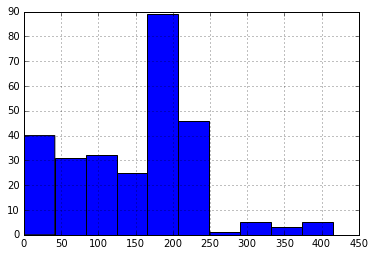

In [320]:
pandas.Series([len(x) for x in full_day_frames_dict.values()]).hist()

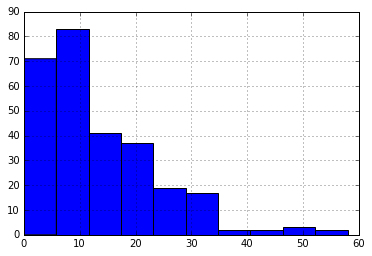

In [332]:
pandas.Series([len([a for a in [a['anim'] for a in n] if a!=0]) for n in full_day_frames_dict.values()]).hist()#.plot(kind='bar')

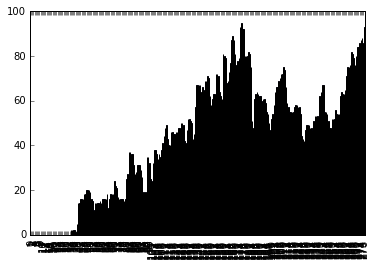

In [426]:
pandas.Series([len([a for a in [a['live_color'] for a in n] if a=='green']) for n in full_day_frames_dict.values()]).plot(kind='bar')

#### Desired geojson 

In [ ]:
{ "type": "FeatureCollection",
    "features": [
        #POLYLINE
        { "type": "Feature",
            "geometry": <INSERT POLYLINE GEOMETRY FROM DF>,
            "properties": {
                "thick": "value0",
                "leg_id" : 1
                "color" :
                "label" :
            }
        },
        #MARKER
        { "type": "Feature",
            "geometry": <INSERT MARKER GEOMETRY FROM DF>,
            "properties": {
                "rad" : 
                "icon" :
                "leg_id" : 1
                "color" :
                "label" :
            }
        },
        #.. repeat
    ]
}

In [427]:
p = re.compile(r'[A-Za-z- ]+, [A-Z]{2}')
def create_polyline_geojson_feature(leg_data, route_info):
    try:
        a = re.search(p, route_info['start_address_f'].tolist()[0]).group().strip() # get only City, ST
    except:
        a = route_info['start_address_f'].tolist()[0]
    try:
        b = re.search(p, route_info['end_address_f'].tolist()[0]).group().strip()
    except:
        b = route_info['start_address_f'].tolist()[0]
        
    title = a + ' to ' + b
        
    desc = {
        'fr' : route_info['start_address_f'].tolist()[0],
        'to' : route_info['end_address_f'].tolist()[0],
        'dst' : route_info['dist_text'].tolist()[0],
        'eta' : route_info['duration_text'].tolist()[0],
        'stt' : str(route_info['start_time'].tolist()[0]),
        'res' : str(leg_data['reservations_now']), 
        'cap' : str(route_info['bus_size'].tolist()[0])
    }
    ft = '{ "type": "Feature", ' + \
            '"geometry": ' + route_info['geometry_line'].tolist()[0] + ', ' + \
            '"properties": {' + \
                '"title" : "' + title + '",' + \
                '"p_o_f" : ' + str(leg_data['percent_of_full']) + ',' + \
                '"leg_id" : ' + str(leg_data['leg_id']) + ',' + \
                '"publ" : "' + str(leg_data['publ']) + '",' + \
                '"anim" : "' + str(leg_data['anim']) + '",' + \
                '"desc" : '+ json.dumps(desc) +',' + \
                '"color" : "' + leg_data['live_color'] + '"}}'
    return ft

def create_marker_geojson_feature(leg_data, route_info):
    tt = str(leg_data['reservations_now']) + ' riders'
    if leg_data['live_color'] == 'green': 
        tt = 'Live: ' + tt
        tt.replace(' riders', '/'+str(route_info['bus_size'].tolist()[0]) +' riders')
    color = make_html_color(leg_data['live_color'])   
    desc = {
        'fr' : route_info['start_address_f'].tolist()[0],
        'to' : route_info['end_address_f'].tolist()[0],
        'dst' : route_info['dist_text'].tolist()[0],
        'eta' : route_info['duration_text'].tolist()[0],
        'stt' : str(route_info['start_time'].tolist()[0]),
        'res' : str(leg_data['reservations_now']), 
        'cap' : str(route_info['bus_size'].tolist()[0])
    }
    ft_start = '{ "type": "Feature",' + \
            '"geometry": ' + route_info['geometry_marker_s'].tolist()[0] + ', ' + \
            '"properties": {' + \
                '"p_o_f" : ' + str(leg_data['percent_of_full']) + ', ' + \
                '"leg_id" : ' + str(leg_data['leg_id']) + ', ' + \
                '"color" : "' + leg_data['live_color'] + '", ' + \
                '"title" : "' + tt + '",' + \
                '"publ" : "' + str(leg_data['publ']) + '",' + \
                '"anim" : "' + str(leg_data['anim']) + '",' + \
                '"desc" : '+ json.dumps(desc) +',' + \
                '"pos": 0}}'
    ft_end = '{ "type": "Feature",' + \
            '"geometry": ' + route_info['geometry_marker_e'].tolist()[0] + ', ' + \
            '"properties": {' + \
                '"p_o_f" : ' + str(leg_data['percent_of_full']) + ', ' + \
                '"leg_id" : ' + str(leg_data['leg_id']) + ', ' + \
                '"color" : "' + leg_data['live_color'] + '", ' + \
                '"title" : "' + tt + '",' + \
                '"publ" : "' + str(leg_data['publ']) + '",' + \
                '"anim" : "' + str(leg_data['anim']) + '",' + \
                '"desc" : '+ json.dumps(desc) +',' + \
                '"pos" : 1}}'
    return [ft_start, ft_end]

def create_geojson_lines_frame(frame_no, frame_data):
    line_list = list()
    marker_list = list()
    for leg in frame_data:
        route_info = all_legs_with_routes[all_legs_with_routes.leg_id == leg['leg_id']]
        line_list.append(create_polyline_geojson_feature(leg, route_info))
        marker_list.extend(create_marker_geojson_feature(leg, route_info))
    return '{ "type": "FeatureCollection", "features": [' + ', '.join(line_list) + ']}', \
                '{ "type": "FeatureCollection", "features": [' + ', '.join(marker_list) + ']}'

In [122]:
all_legs_with_routes.iloc[0]

event_id                                                        1317
leg_id                                                          2512
state_origin                                                      NY
state_dest                                                        NY
is_public                                                      False
bus_size                                                          12
go_live                                                            1
created_at                                2015-06-24 19:40:38.237000
live_ratio                                                      0.08
start_time                                       2015-06-26 13:00:00
dist_text                                                     0.7 mi
dist_meters                                                     1097
duration_text                                                 5 mins
duration_sec                                                     296
geometry_line      {"type": "LineS

In [411]:
test = create_geojson_frame(201, full_day_frames_dict[201])

In [423]:
print(json.dumps(json.loads(test[0])['features'][2], indent=4))

{
    "geometry": {
        "type": "LineString",
        "coordinates": [
            [
                -73.97642,
                40.72386
            ],
            [
                -74.007,
                40.72478
            ],
            [
                -74.06767,
                40.74085
            ],
            [
                -74.09406,
                40.74581
            ],
            [
                -74.16358,
                40.74775
            ],
            [
                -74.23756,
                40.77129
            ],
            [
                -74.28355,
                40.80436
            ],
            [
                -74.34873,
                40.84531
            ],
            [
                -74.44835,
                40.86795
            ],
            [
                -74.50239,
                40.90882
            ],
            [
                -74.68275,
                40.8902
            ],
            [
                -74.767

In [417]:
frm = 201
l, m = create_geojson_frame(frm, full_day_frames_dict[frm])
with open("geojson_frames/line_" + str(frm) + ".geojson", "w") as file:
    file.write(l)
with open("geojson_frames/marker_" + str(frm) + ".geojson", "w") as file:
    file.write(m)

In [210]:
for frm in full_day_frames_dict.keys():
    l, m = create_geojson_frame(frm, full_day_frames_dict[frm])
    with open("geojson_frames/line_" + str(frm) + ".geojson", "w") as file:
        file.write(l)
    with open("geojson_frames/marker_" + str(frm) + ".geojson", "w") as file:
        file.write(m)

In [161]:
# 32 Mb of data

In [370]:
full_day_frames_dict[201]

[{'anim': 0,
  'leg_id': 4101,
  'live_color': 'red',
  'percent_of_full': 0.0,
  'progress_to_live': 0.0,
  'publ': 1,
  'reservations_now': 0},
 {'anim': 0,
  'leg_id': 4102,
  'live_color': 'red',
  'percent_of_full': 0.0,
  'progress_to_live': 0.0,
  'publ': 1,
  'reservations_now': 0},
 {'anim': 0,
  'leg_id': 4103,
  'live_color': 'red',
  'percent_of_full': 0.0,
  'progress_to_live': 0.0,
  'publ': 1,
  'reservations_now': 0},
 {'anim': 0,
  'leg_id': 4104,
  'live_color': 'red',
  'percent_of_full': 0.0,
  'progress_to_live': 0.0,
  'publ': 1,
  'reservations_now': 0},
 {'anim': 0,
  'leg_id': 3751,
  'live_color': 'green',
  'percent_of_full': 1.0,
  'progress_to_live': 1,
  'publ': 0,
  'reservations_now': 36},
 {'anim': 0,
  'leg_id': 4114,
  'live_color': 'green',
  'percent_of_full': 1.0,
  'progress_to_live': 1,
  'publ': 0,
  'reservations_now': 45},
 {'anim': 0,
  'leg_id': 3609,
  'live_color': 'red',
  'percent_of_full': 0.0,
  'progress_to_live': 0.0,
  'publ': 1,
  

In [372]:
# index of max non-red values:
l = [sum(list(map(lambda t: 1 if t == True else 0 ,[x['progress_to_live'] > 0.6 for x in frame]))) for frame in full_day_frames_dict.values()]
l.index(max(l))

174

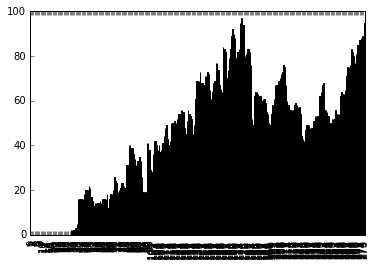

In [373]:
pandas.Series(l).plot(kind='bar')

### High Quality Polylines

In [216]:
all_legs_HQ_polylines = pandas.read_excel('processed_data/all_legs_with_routes_hq_polylines.xlsx')

In [221]:
def create_HQ_geojson_frame(frame_no, frame_data):
    line_list = list()
    marker_list = list()
    for leg in frame_data:
        route_info = all_legs_HQ_polylines[all_legs_HQ_polylines.leg_id == leg['leg_id']]
        line_list.append(create_polyline_geojson_feature(leg, route_info))
    return '{ "type": "FeatureCollection", "features": [' + ', '.join(line_list) + ']}'

In [200]:
for frm in full_day_frames_dict.keys():
    l = create_HQ_geojson_frame(frm, full_day_frames_dict[frm])
    with open("HQ_geojson_frames/line_" + str(frm) + ".geojson", "w") as file:
        file.write(l)

### Route information data

### Upload geojson frames directly to meteor Mongo.
> meteor mongo -U

to find out connection params

In [444]:
from pymongo import MongoClient
mcl = MongoClient('mongodb://127.0.0.1:3001/')
db = mcl.meteor

In [445]:
lines_coll = db.geojson_lines 
linesHQ_coll = db.geojson_linesHQ
markers_coll = db.geojson_markers

In [446]:
gjf = [create_geojson_frame(frm, full_day_frames_dict[frm]) for frm in full_day_frames_dict.keys()]
lines_coll.insert([{'frame' : frm, 'gj' : gj[0]} for frm, gj in enumerate(gjf)])
markers_coll.insert([{'frame' : frm, 'gj' : gj[1]} for frm, gj in enumerate(gjf)])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  app.launch_new_instance()


[ObjectId('56d8c6febf2f1536200cc157'),
 ObjectId('56d8c6febf2f1536200cc158'),
 ObjectId('56d8c6febf2f1536200cc159'),
 ObjectId('56d8c6febf2f1536200cc15a'),
 ObjectId('56d8c6febf2f1536200cc15b'),
 ObjectId('56d8c6febf2f1536200cc15c'),
 ObjectId('56d8c6febf2f1536200cc15d'),
 ObjectId('56d8c6febf2f1536200cc15e'),
 ObjectId('56d8c6febf2f1536200cc15f'),
 ObjectId('56d8c6febf2f1536200cc160'),
 ObjectId('56d8c6febf2f1536200cc161'),
 ObjectId('56d8c6febf2f1536200cc162'),
 ObjectId('56d8c6febf2f1536200cc163'),
 ObjectId('56d8c6febf2f1536200cc164'),
 ObjectId('56d8c6febf2f1536200cc165'),
 ObjectId('56d8c6febf2f1536200cc166'),
 ObjectId('56d8c6febf2f1536200cc167'),
 ObjectId('56d8c6febf2f1536200cc168'),
 ObjectId('56d8c6febf2f1536200cc169'),
 ObjectId('56d8c6febf2f1536200cc16a'),
 ObjectId('56d8c6febf2f1536200cc16b'),
 ObjectId('56d8c6febf2f1536200cc16c'),
 ObjectId('56d8c6febf2f1536200cc16d'),
 ObjectId('56d8c6febf2f1536200cc16e'),
 ObjectId('56d8c6febf2f1536200cc16f'),
 ObjectId('56d8c6febf2f15

In [447]:
linesHQ_coll.insert([{'frame' : f, 'gj' : create_HQ_geojson_frame(f, full_day_frames_dict[f])} for f in full_day_frames_dict.keys()])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  if __name__ == '__main__':


[ObjectId('56d8c727bf2f1536200cc26c'),
 ObjectId('56d8c727bf2f1536200cc26d'),
 ObjectId('56d8c727bf2f1536200cc26e'),
 ObjectId('56d8c727bf2f1536200cc26f'),
 ObjectId('56d8c727bf2f1536200cc270'),
 ObjectId('56d8c727bf2f1536200cc271'),
 ObjectId('56d8c727bf2f1536200cc272'),
 ObjectId('56d8c727bf2f1536200cc273'),
 ObjectId('56d8c727bf2f1536200cc274'),
 ObjectId('56d8c727bf2f1536200cc275'),
 ObjectId('56d8c727bf2f1536200cc276'),
 ObjectId('56d8c727bf2f1536200cc277'),
 ObjectId('56d8c727bf2f1536200cc278'),
 ObjectId('56d8c727bf2f1536200cc279'),
 ObjectId('56d8c727bf2f1536200cc27a'),
 ObjectId('56d8c727bf2f1536200cc27b'),
 ObjectId('56d8c727bf2f1536200cc27c'),
 ObjectId('56d8c727bf2f1536200cc27d'),
 ObjectId('56d8c727bf2f1536200cc27e'),
 ObjectId('56d8c727bf2f1536200cc27f'),
 ObjectId('56d8c727bf2f1536200cc280'),
 ObjectId('56d8c727bf2f1536200cc281'),
 ObjectId('56d8c727bf2f1536200cc282'),
 ObjectId('56d8c727bf2f1536200cc283'),
 ObjectId('56d8c727bf2f1536200cc284'),
 ObjectId('56d8c727bf2f15

In [436]:
linesHQ_coll.delete_many({});

lines_coll.delete_many({});

markers_coll.delete_many({});

## Data tasks
1. include dissolving info
1. include route description
2. line titles
3. public/private

>All Done

#### IDEA: frame visibilty control through dictionary:
> visible_from[leg_id] = frame_number

> visible_until[leg_id] = frame_number

> "filter": [
>                                        ">=",
>                                        frame,
>                                        "visible_from"
>                                    ]

#### may actually need to be a property in the geojson